Here we open the json data and normalize the data such that each row corresponds to one ingredient.

The dataset has already been parsed by a CRF model to turn the freeform recipe ingredients into structured data (name, unit, quantity).

In [10]:
import pandas as pd
import json

with open('enriched_recipes.json') as f:
    data = json.load(f)
    df = pd.json_normalize(
        data, 'parsed_ingredients',
        meta=['author',
              'photo_url',
              'prep_time_minutes',
              'rating_stars',
              'review_count',
              'title',
              'total_time_minutes',
              'url'
             ],
        record_prefix='ingredient_', errors='ignore')

The output data looks like this:

Filter the data where recipe ratings are valid (more than 20 reviews and more than 0 stars).

Then, group the ingredients by ingredient name, and average each ingredient's numerical rating.

In [11]:
df["ingredient_name"] = df["ingredient_name"].str.lower()

name_cleaning_map = {
    "egg": "eggs",
    "tomato": "tomatoes",
    "all-purpose flour": "flour",
    "sugar": "white sugar",
    "salt and black pepper": "salt and pepper",
    "carrot": "carrots",
    "basil leaves": "basil",
    "mozzarella cheese": "mozzarella",
    "parmesan cheese": "parmesan",
    "feta cheese": "feta",
    "confectioners' sugar": "powdered sugar",
    "oil": "vegetable oil",
    "heavy whipping cream": "heavy cream",
    "green onion": "green onions",
    "chicken breast": "chicken breasts",
    "pepper": "black pepper",
}

df["ingredient_name"] = df["ingredient_name"].apply(
    lambda name: name_cleaning_map.get(name, name))


In [12]:
# pareto principle
NUM_INGREDIENTS = round(len(df["ingredient_name"].unique()) * .2)

NUM_INGREDIENTS = 100

ingredient_count = df.groupby(
    "ingredient_name"
).agg(
    ingredient_count=("ingredient_name", "count")
).nlargest(
    NUM_INGREDIENTS,
    columns=["ingredient_count"]
).reset_index()

common_ingredients = set(ingredient_count["ingredient_name"])

common_subset = df.loc[
    df["ingredient_name"].isin(common_ingredients)
]

len(common_subset) / len(df)

0.6117202367859841

In [13]:
# from https://www.britannica.com/topic/list-of-herbs-and-spices-2024392
spices = [
    'allspice',
    'angelica',
    'anise',
    'asafoetida',
    'bay leaf',
    'basil',
    'bergamot',
    'black cumin',
    'black mustard',
    'black pepper',
    'borage',
    'brown mustard',
    'burnet',
    'caraway',
    'cardamom',
    'cassia',
    'catnip',
    'cayenne pepper',
    'celery seed',
    'chervil',
    'chicory',
    'chili pepper',
    'chives',
    'cicely',
    'cilantro',
    'cinnamon',
    'clove',
    'coriander',
    'costmary',
    'cumin',
    'curry',
    'dill',
    'fennel',
    'fenugreek',
    'filé',
    'garlic powder',
    'ginger',
    'grains of paradise',
    'holy basil',
    'horehound',
    'horseradish',
    'hyssop',
    'lavender',
    'lemon balm',
    'lemon grass',
    'lemon verbena',
    'licorice',
    'lovage',
    'mace',
    'marjoram',
    'nutmeg',
    'oregano',
    'onion powder',
    'paprika',
    'parsley',
    'peppermint',
    'poppy seed',
    'rosemary',
    'rue',
    'saffron',
    'sage',
    'savory',
    'sesame',
    'sorrel',
    'star anise',
    'spearmint',
    'tarragon',
    'thyme',
    'tumeric',
    'vanilla',
    'wasabi',
    'white mustard'
]

In [39]:
spices_regex = r"|".join(spices)

recipes_with_spices = df.loc[df['ingredient_name'].str.contains(spices_regex).fillna(False)]

replace_dict = {}

for spice in spices:
    replace_dict[f".*{spice}.*"] = spice

recipes_with_spices['spice'] = recipes_with_spices['ingredient_name'].replace(replace_dict, regex=True)

/tmp/ipykernel_21966/3663026639.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipes_with_spices['spice'] = recipes_with_spices['ingredient_name'].replace(replace_dict, regex=True)


In [15]:
len(recipes_with_spices) / len(df)

0.1347748333604292

In [41]:
common_spices = set(
    recipes_with_spices['spice'].value_counts().head(20).index
)
recipes_with_spices['spice'].value_counts()[:30]

black pepper      16999
vanilla           14990
cinnamon           9323
parsley            6578
ginger             5402
basil              5045
garlic powder      4395
cilantro           4126
nutmeg             3784
cumin              3696
sage               3633
oregano            3618
thyme              3491
cayenne pepper     3126
paprika            3059
clove              2382
sesame             2363
dill               1930
rosemary           1912
curry              1502
onion powder       1378
allspice           1142
chives             1043
bay leaf            995
coriander           882
tarragon            696
fennel              576
horseradish         574
cardamom            556
celery seed         430
Name: spice, dtype: int64

In [17]:
spices_count = recipes_with_spices.groupby(
    "url", as_index=False
).agg(
    spices_count=("spice", "count"), url=("url", "first")
)

spices_count
recipes_with_spices
recipes_with_spices_with_count = recipes_with_spices.merge(
    spices_count, on="url"
)

multi_spice_recipes = recipes_with_spices_with_count.loc[
    recipes_with_spices_with_count["spices_count"] > 1
]

common_multi_spice_recipes = multi_spice_recipes[
    multi_spice_recipes['spice'].isin(common_spices)
]

dummy = pd.get_dummies(
    common_multi_spice_recipes,
    columns=["spice"],
    prefix='',
    prefix_sep=''
).groupby(['url'], as_index=False).max()

/tmp/ipykernel_21966/935013054.py:26: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ).groupby(['url'], as_index=False).max()


In [18]:
spice_corr = dummy.drop(columns=multi_spice_recipes.columns, errors="ignore")
corr = spice_corr.corr()

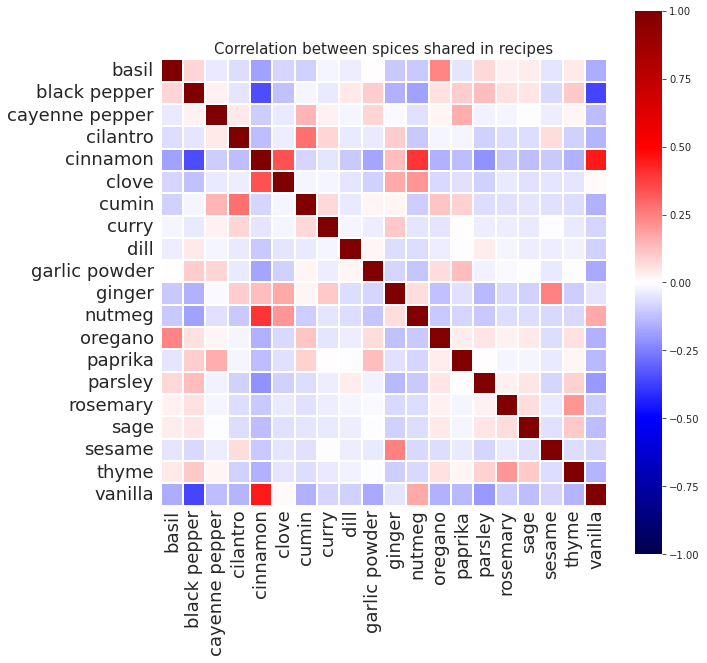

In [58]:
# plot spices correlation matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 10]

from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)

with sns.axes_style("white"):
    f, ax = plt.subplots()
    ax.tick_params(axis='x', labelrotation=45, length=0)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    plt.title("Correlation between spices shared in recipes", fontsize=15)
    
    ax2 = sns.heatmap(corr, cmap="seismic", square=True, linewidths=2, norm=divnorm)
    ax2.tick_params(left=False, bottom=False)


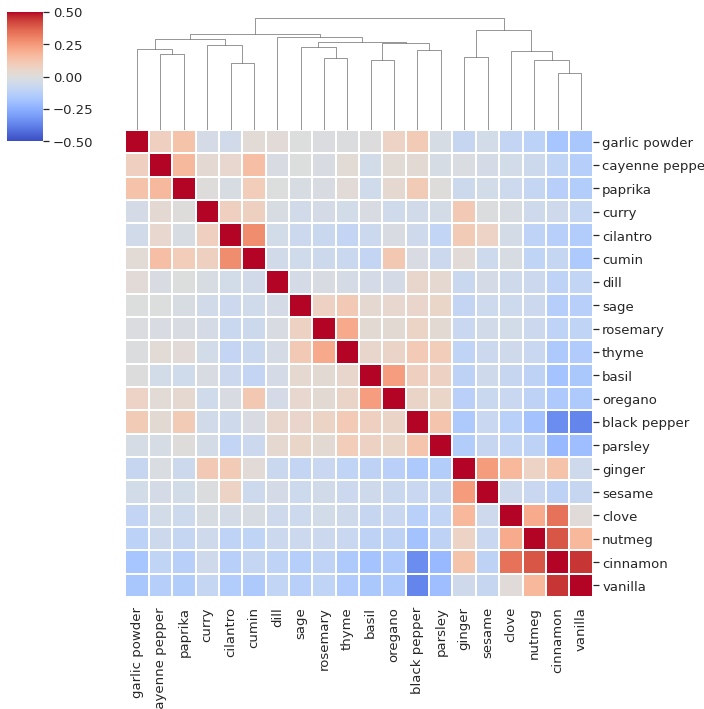

In [108]:
# plot spices correlation matrix
with sns.axes_style("white"):
    # plt.title("Correlation between spices shared in recipes", fontsize=15)
    # sns.set(font_scale=1.2)
    ax2 = sns.clustermap(corr, cmap="coolwarm", linewidths=2, vmin=-.5, vmax=.5, annot=False)
    ax2.ax_row_dendrogram.set_visible(False)


In [133]:
# normalize ingredient quantity

def convert_to_float(frac_str):
    frac_str = frac_str.strip()

    if " " in frac_str and "/" not in frac_str:
        return None
    try:
        return float(frac_str)
    except ValueError:
        if "/" not in frac_str:
            return None
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        try:
            frac = float(num) / float(denom)
            return whole - frac if whole < 0 else whole + frac
        except Exception as e:
            return None

has_qty = df[df['ingredient_qty'].notnull()]

has_qty["quantity_float"] = has_qty["ingredient_qty"].apply(convert_to_float)

has_qty_float = has_qty.loc[has_qty["quantity_float"].notnull()]

has_qty_float
has_qty.loc[has_qty["ingredient_unit"] =="tablespoon"]["ingredient_name"].value_counts()[:50]

/tmp/ipykernel_29610/80687927.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_qty["quantity_float"] = has_qty["ingredient_qty"].apply(convert_to_float)


butter                    10418
olive oil                  9230
vegetable oil              4649
white sugar                4572
lemon juice                3844
flour                      3477
water                      2747
parsley                    2583
brown sugar                1968
soy sauce                  1966
cornstarch                 1866
honey                      1667
milk                       1586
garlic                     1424
lime juice                 1392
unsalted butter            1293
salt                       1271
cilantro                   1246
parmesan                   1215
worcestershire sauce       1200
basil                      1089
onion                      1065
dijon mustard               874
chili powder                871
vanilla extract             854
canola oil                  846
baking powder               790
mayonnaise                  778
balsamic vinegar            747
ginger                      723
margarine                   696
cinnamon

In [24]:
NUM_INGREDIENTS = 100

ingredient_count = df.groupby(
    "ingredient_name"
).agg(
    ingredient_count=("ingredient_name", "count")
).nlargest(
    NUM_INGREDIENTS,
    columns=["ingredient_count"]
).reset_index()

common_ingredients = set(ingredient_count["ingredient_name"])

common_subset = df.loc[
    df["ingredient_name"].isin(common_ingredients)
]


0.6117202367859841

In [88]:
rating_by_ingredient = common_subset.groupby(
    "ingredient_name"
).agg(
    avg_rating=("rating_stars", "mean"),
    rating_count=("ingredient_name", "count")
).reset_index()

rating_by_ingredient.sort_values(by="avg_rating")[-5:]

,ingredient_name,avg_rating,rating_count
4216,keebler sandies pecan shortbread cookies,5.0,4
1507,archer farms wheat kaiser rolls,5.0,3
1501,archer farms sweet & tangy teriyaki marinade,5.0,3
3887,herdez red guajillo chile mexican cooking sauce,5.0,5
5194,packets wholesome organic stevia,5.0,4


In [135]:
sr_28 = pd.read_csv("ABBREV.csv")

sr28_descriptions = {
    "unsalted butter": "BUTTER,WITHOUT SALT",
    "flour": "WHEAT FLOURS,BREAD,UNENR",
    "salt": "SALT,TABLE",
    "white sugar": "SUGARS,GRANULATED",
    "baking powder": "LEAVENING AGENTS,BAKING PDR,DOUBLE-ACTING,STRAIGHT PO4",
    "baking soda": "LEAVENING AGENTS,BAKING SODA",
    "buttermilk": "MILK,BTTRMLK,FLUID,WHL",
    "eggs": "EGG,WHL,RAW,FRSH",
    "basil": "SPICES,BASIL,DRIED",
    "parmesan": "CHEESE,PARMESAN,GRATED",
    # lol
    "water": "WATER,BTLD,GENERIC",
    "margarine": "MARGARINE,REG,80% FAT,COMP,STK,W/ SALT",
    "vegetable oil": "USDA CMDTY FD,OIL,VEG,SOYBN,REFINED",
    "butter": "BUTTER,WITH SALT",
    "milk": "MILK,RED FAT,FLUID,2% MILKFAT,WO/ ADDED VIT A & VIT D",
    "sour cream": "SOUR CREAM,LIGHT",
    "shortening": "SHORTENING,HOUSEHOLD,LARD&VEG OIL",
    "walnuts": "WALNUTS,ENGLISH",
    "raisins": "RAISINS,SEEDLESS",
    "green onions": "ONIONS,SPRING OR SCALLIONS (INCL TOPS&BULB),RAW",
    "olive oil": "OIL,OLIVE,SALAD OR COOKING",
    "cocoa powder": "COCOA,DRY PDR,UNSWTND",
    "onion": "ONIONS,RAW",
    # garlic salt is mostly salt, with some garlic
    "garlic salt": "SALT,TABLE",
    "zucchini": "SQUASH,SMMR,ZUCCHINI,INCL SKN,RAW",
    "mozzarella": "CHEESE,MOZZARELLA,WHL MILK",
    "brown sugar": "SUGARS,BROWN",
    "powdered sugar": "SUGARS,POWDERED",
    "lemon": "LEMON JUICE,RAW",
    "oregano": "SPICES,OREGANO,DRIED",
    "chocolate chips": "CANDIES,SEMISWEET CHOC",
    "coconut": "COCONUT MEAT,DRIED (DESICCATED),NOT SWTND",
    "mayonnaise": "MAYONNAISE,RED FAT,W/ OLIVE OIL",
    "thyme": "SPICES,THYME,DRIED",
    "red pepper flakes": "PEPPER,RED OR CAYENNE",
    "cayenne pepper": "PEPPER,RED OR CAYENNE",
    "apples": "APPLES,RAW,WITH SKIN",
    "peanut butter": "PEANUT BUTTER,SMOOTH STYLE,W/ SALT",
    "potatoes": "POTATOES,RAW,SKIN",
    "heavy cream": "CREAM,FLUID,HVY WHIPPING",
    "green bell pepper": "PEPPERS,SWT,GRN,RAW",
    "red bell pepper": "PEPPERS,SWT,RED,RAW",
    "shrimp": "CRUSTACEANS,SHRIMP,MXD SP,RAW (MAYBE PREVIOUSLY FROZEN)",
    "cumin": "CUMIN SEED",
    "mushrooms": "MUSHROOMS,WHITE,RAW",
    "lime": "LIMES,RAW",
    "soy sauce": "SOY SAU MADE FROM HYDROLYZED VEG PROT",
    "chicken broth": "SOUP,CHICK BROTH,RTS",
    "white vinegar": "VINEGAR,DISTILLED",
    "tomato paste": "TOMATO PRODUCTS,CND,PASTE,WO/ SALT ADDED",
    "tomato sauce": "TOMATO PRODUCTS,CND,SAU",

    # close enough?
    "almond extract": "VANILLA EXTRACT",
    "chicken breasts": "CHICKEN,BROILERS OR FRYERS,MEAT & SKN,RAW",
    "bread crumbs": "BREAD CRUMBS,DRY,GRATED,PLN",
    "chicken": "CHICKEN,BROILERS OR FRYERS,MEAT & SKN,RAW",
    "ham": "HAM,CHOPPED,NOT CANNED",
    "tomatoes": "TOMATOES,RED,RIPE,RAW,YEAR RND AVERAGE",
    "bacon": "PORK,CURED,BACON,CKD,BRLD,PAN-FRIED OR RSTD,RED NA",
    "mustard": "MUSTARD,PREPARED,YELLOW",
    "beef": "BEEF,GRASS-FED,STRIP STEAKS,LN,RAW",
    "cilantro": "CORIANDER (CILANTRO) LEAVES,RAW",
    "red onion": "ONIONS,RAW",
    "ketchup": "Catsup",
    "dijon mustard": "MUSTARD,PREPARED,YELLOW",
    "cooking spray": "OIL,PAM COOKING SPRAY,ORIGINAL",
    "hot pepper sauce": "SAUCE,RTS,PEPPER OR HOT",
    "salt and pepper": "SALT,TABLE",
}

unique_ingredients = common_subset["ingredient_name"].unique()

def find_sr_28_description(ingredient):
    if ingredient in sr28_descriptions:
        return sr28_descriptions[ingredient]

    split_ingredient = ingredient.upper().split(" ", 2)
    if len(split_ingredient) > 1:
        reformatted = split_ingredient[1] + "," + split_ingredient[0]
    else:
        reformatted = ingredient.upper()

    has_ingredient = (sr_28.loc[
        (sr_28["Shrt_Desc"] == sr28_descriptions.get(ingredient)) | 
        (sr_28["Shrt_Desc"] == reformatted) |
        (sr_28["Shrt_Desc"] == ingredient.upper()) |
        (sr_28["Shrt_Desc"] == (ingredient.upper() + ",RAW")) |
        (sr_28["Shrt_Desc"] == (ingredient.upper() + ",DRIED")) |
        (sr_28["Shrt_Desc"] == (ingredient.upper() + ",GROUND"))
    ])

    # cache the ingredient
    sr28_descriptions[ingredient] = has_ingredient["Shrt_Desc"].head().item()

    return has_ingredient["Shrt_Desc"].head().item()

common_subset["Shrt_Desc"] = common_subset["ingredient_name"].apply(
    find_sr_28_description)

common_sr28 = sr_28[sr_28["Shrt_Desc"].isin(
    common_subset["Shrt_Desc"].unique()
)]

/tmp/ipykernel_29610/3823601925.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_subset["Shrt_Desc"] = common_subset["ingredient_name"].apply(


In [136]:
from pint import UnitRegistry
import pint_pandas

ureg = UnitRegistry()

def find_density(row):
    gram1 = row["GmWt_1"]
    gram2 = row["GmWt_2"]
            
    vol1 = row["GmWt_Desc1"]
    vol2 = row["GmWt_Desc2"]

    density_input_attempts = [
        (gram1, vol1),
    ]

    if vol2:
        density_input_attempts.append((gram2, vol2))

    if vol1 and type(vol1) != float and "," in vol1:
        density_input_attempts.append(
            (gram1, vol1.split(",")[0])
        )

    if vol2 and type(vol2) != float and "," in vol2:
        density_input_attempts.append(
            (gram2, vol2.split(",")[0])
        )

    for gram, vol in density_input_attempts:
        try:
            volume = ureg(vol)
            assert volume.is_compatible_with("cup")
            mass_grams = ureg.gram * float(gram)
            return mass_grams / volume
        except Exception:
            "ok"
    return None

common_sr28["density"] = common_sr28.apply(find_density, axis="columns")

/home/william/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1983: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/tmp/ipykernel_29610/2300586339.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_sr28["density"] = common_sr28.apply(find_density, axis="columns")


In [137]:
with_weights = common_subset.merge(common_sr28[["Shrt_Desc", "GmWt_1","GmWt_2","GmWt_Desc1","GmWt_Desc2", "density"]], on="Shrt_Desc")

has_qty_and_weights = with_weights[with_weights['ingredient_qty'].notnull()]

has_qty_and_weights["quantity_float"] = has_qty_and_weights["ingredient_qty"].apply(convert_to_float)

has_qty_and_weights = has_qty_and_weights.loc[has_qty_and_weights["quantity_float"].notnull()]

def weight_in_grams(row):
    try:
        qty = row["quantity_float"]
        unit = ureg(row["ingredient_unit"])
        density = row["density"]

        # workaround for the actual unit called "bag" = 94 pounds
        if row["ingredient_unit"] == "bag":
            return None

        # NOT a pico inch
        if row["ingredient_unit"] == "pinch":
            return None

        if unit.is_compatible_with("gram"):
            return (qty * unit).to_base_units().magnitude * 1000
        elif unit.is_compatible_with("cup"):
            weight_grams = qty * unit * density
            return weight_grams.to_base_units().magnitude * 1000
        else:
            return None
    except Exception as e:
        return None

has_qty_and_weights["weight_in_grams"] = has_qty_and_weights.apply(weight_in_grams, axis="columns")

/tmp/ipykernel_29610/3863671586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  has_qty_and_weights["quantity_float"] = has_qty_and_weights["ingredient_qty"].apply(convert_to_float)


In [148]:
has_qty_and_weights
weight_by_ingredient = has_qty_and_weights.groupby(
    "ingredient_name"
).agg(avg_weight_grams=("weight_in_grams", "mean")).reset_index()

rating_by_ingredient = df.where(
    df['rating_stars'] > 0
).where(
    df['review_count'] > 20
).groupby(
    "ingredient_name"
).agg(
    avg_rating=("rating_stars", "mean")
).reset_index()

weight_by_ingredient.sort_values(by="avg_weight_grams")

,ingredient_name,avg_weight_grams
59,nutmeg,1.371205
26,cloves,1.467672
87,thyme,1.544303
66,oregano,1.713830
16,cayenne pepper,1.810886
...,...,...
21,chicken broth,587.223243
2,apples,606.247989
19,chicken,634.776698
72,potatoes,1005.257593


<AxesSubplot:>

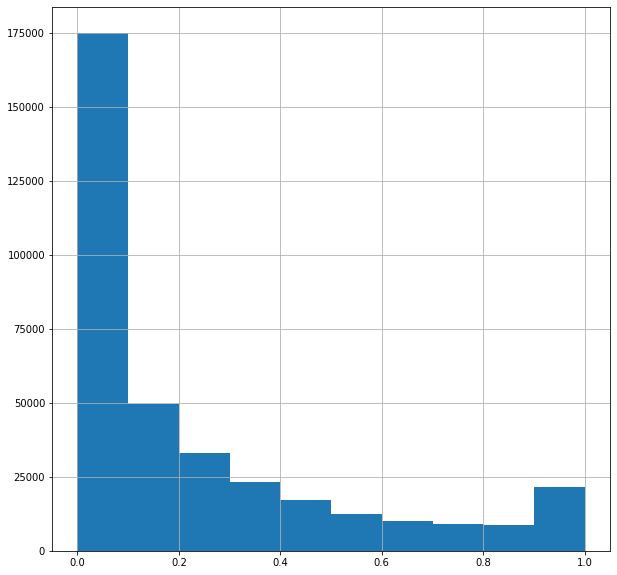

In [ ]:
totals = has_qty_and_weights.groupby("url").agg(
    total_weight=("weight_in_grams", "sum"),
)

# len(has_qty_and_weights.dropna(subset="weight_in_grams")["ingredient_unit"])
# 359880.0 / 469190

# has_qty_and_weights.loc[has_qty_and_weights["quantity_float"].isnull()]

# has_qty_and_weights.loc[has_qty_and_weights["ingredient_name"] == "almonds"]["weight_in_grams"].hist(bins=20)

has_qty_and_weights
with_totals = has_qty_and_weights.join(
    totals,
    on="url",
    how="left",
)
with_totals

with_totals["weight_fraction"] = with_totals["weight_in_grams"] / with_totals["total_weight"]
# with_totals.loc[with_totals["ingredient_name"] == "butter"]["weight_fraction"].hist()
with_totals[["ingredient_name", "weight_fraction", "url", "total_weight"]]

with_totals.loc[with_totals["url"] == "http://allrecipes.com/Recipe/6664/"]

with_totals["weight_fraction"].hist()

In [ ]:
with_totals.groupby("ingredient_name").agg(
    med_fraction=("weight_fraction", "median"),
    fraction_qty=("weight_fraction", "count")
).sort_values(by="med_fraction")

with_totals.loc[with_totals["ingredient_name"] == "lime juice"]

,ingredient_comment,ingredient_input,ingredient_name,ingredient_other,ingredient_qty,ingredient_unit,ingredient_range_end,author,photo_url,prep_time_minutes,...,Shrt_Desc,GmWt_1,GmWt_2,GmWt_Desc1,GmWt_Desc2,density,quantity_float,weight_in_grams,total_weight,weight_fraction
466191,fresh,1 teaspoon fresh lime juice,lime juice,NaN,1,teaspoon,NaN,JJOHN32,http://images.media-allrecipes.com/userphotos/...,80,...,"LIME JUICE,RAW",242.0,30.8,1 cup,1 fl oz,242.0 gram / cup,1.0,5.041667,929.141667,0.005426
466192,fresh,1 cup fresh lime juice,lime juice,NaN,1,cup,NaN,JJOHN32,http://images.media-allrecipes.com/userphotos/...,80,...,"LIME JUICE,RAW",242.0,30.8,1 cup,1 fl oz,242.0 gram / cup,1.0,242.000000,929.141667,0.260455
466193,fresh,3 tablespoons fresh lime juice,lime juice,NaN,3,tablespoon,NaN,Judy,http://images.media-allrecipes.com/userphotos/...,0,...,"LIME JUICE,RAW",242.0,30.8,1 cup,1 fl oz,242.0 gram / cup,3.0,45.375000,824.975000,0.055002
466194,NaN,1 tablespoon lime juice,lime juice,NaN,1,tablespoon,NaN,Cathy Anderson,http://images.media-allrecipes.com/userphotos/...,20,...,"LIME JUICE,RAW",242.0,30.8,1 cup,1 fl oz,242.0 gram / cup,1.0,15.125000,96.825000,0.156210
466195,fresh,5 tablespoons fresh lime juice,lime juice,NaN,5,tablespoon,NaN,CHRISTYJ,http://images.media-allrecipes.com/userphotos/...,0,...,"LIME JUICE,RAW",242.0,30.8,1 cup,1 fl oz,242.0 gram / cup,5.0,75.625000,415.225000,0.182130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468629,NaN,2 tablespoons lime juice,lime juice,NaN,2,tablespoon,NaN,paralee,http://images.media-allrecipes.com/global/reci...,58,...,"LIME JUICE,RAW",242.0,30.8,1 cup,1 fl oz,242.0 gram / cup,2.0,30.250000,771.237500,0.039223
468630,NaN,1 tablespoon lime juice,lime juice,NaN,1,tablespoon,NaN,Classy Pour,http://images.media-allrecipes.com/global/reci...,4,...,"LIME JUICE,RAW",242.0,30.8,1 cup,1 fl oz,242.0 gram / cup,1.0,15.125000,436.671185,0.034637
468631,NaN,2 teaspoons lime juice,lime juice,NaN,2,teaspoon,NaN,Yoly,http://images.media-allrecipes.com/global/reci...,45,...,"LIME JUICE,RAW",242.0,30.8,1 cup,1 fl oz,242.0 gram / cup,2.0,10.083333,388.883333,0.025929
468632,NaN,2 tablespoons lime juice,lime juice,NaN,2,tablespoon,NaN,Nekmor,http://images.media-allrecipes.com/global/reci...,41,...,"LIME JUICE,RAW",242.0,30.8,1 cup,1 fl oz,242.0 gram / cup,2.0,30.250000,61.450000,0.492270


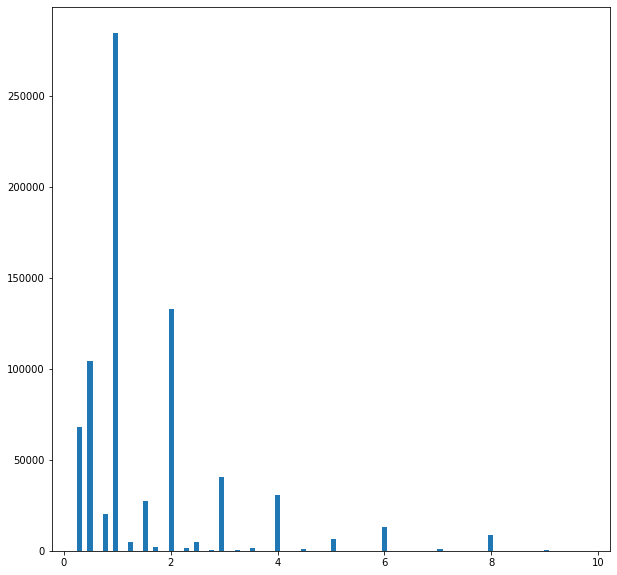

In [ ]:
import pylab as pl
import numpy as np

pl.figure()
pl.hist(has_qty["quantity_float"].where(has_qty["quantity_float"] < 10), bins=100)
pl.show()

In [ ]:
NUM_INGREDIENTS_FOR_GRAPH = 100

ingredient_count = df.groupby(
    "ingredient_name"
).agg(
    ingredient_count=("ingredient_name", "count")
).nlargest(NUM_INGREDIENTS_FOR_GRAPH, columns=["ingredient_count"])

ingredient_count.reset_index(inplace=True)

common_ingredients = set(ingredient_count["ingredient_name"])

common_graph_subset = df.loc[df["ingredient_name"].isin(common_ingredients)]


In [ ]:
common_graph_subset_2 = common_graph_subset.copy()

merged = common_subset.merge(common_graph_subset, on="url")
merged_without_same = merged.loc[merged["ingredient_name_x"] < merged["ingredient_name_y"]]

merged_without_same["edge"] = list(zip(
    merged_without_same["ingredient_name_x"],
    merged_without_same["ingredient_name_y"]))

weights = merged_without_same.groupby("edge").agg(
    edge_weight=("edge", "count"),
    urls=("url", set),
    edge=("edge", "first"),
    ingredient_x=("ingredient_name_x", "first"),
    ingredient_y=("ingredient_name_y", "first"),
)

# test = weights.sort_values('edge_weight', ascending = False).groupby("ingredient_x")['edge_weight'].head(3)

top_3_edges = weights.groupby("ingredient_x").apply(lambda grp: grp.nlargest(3, 'edge_weight'))["ingredient_y"]
weights = pd.merge(top_3_edges, weights, on=["ingredient_x", "ingredient_y"])

weights["edge_weight_normalized"] = weights["edge_weight"] / weights["edge_weight"].max()

weight_tuples = list(zip(
    weights["ingredient_x"],
    weights["ingredient_y"],
    weights["edge_weight_normalized"],
    weights["edge_weight"]))


/tmp/ipykernel_29610/705619299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_without_same["edge"] = list(zip(


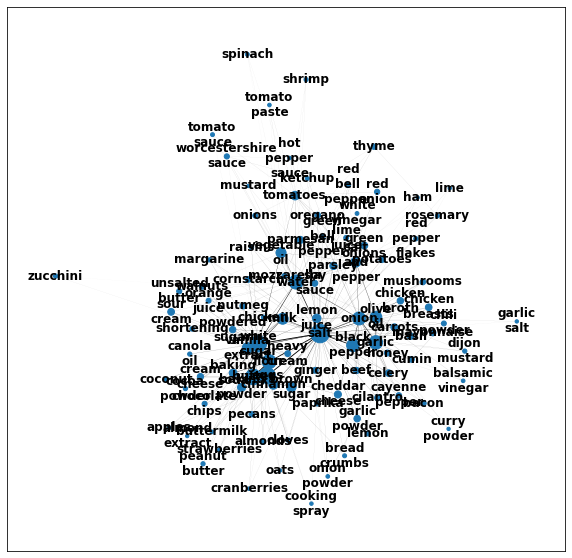

In [ ]:
import networkx as nx

# plot the graph with networkx
G = nx.Graph()
G.add_nodes_from(common_ingredients)

[G.add_edge(u, v, weight=w) for u, v, w, _ in weight_tuples]

edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]

pos = nx.spring_layout(G, iterations=50, seed=9)

node_size=[ingredient_count.loc[
    ingredient_count["ingredient_name"] == n
]["ingredient_count"] / 100 for n in G.nodes()]

nodenames = {n: n.replace(" ", "\n") for n in G.nodes()}

plt.grid(False)

nx.draw_networkx_nodes(G, pos, node_size=node_size)
nx.draw_networkx_labels(G, pos, labels=nodenames, font_weight="bold")
nx.draw_networkx_edges(G, pos, width=edgewidth,)

In [154]:
def float_ignore_na(x):
    return float(x) if pd.notna(x) else None

d3_format = {
    "nodes": [{"size": float_ignore_na(ingredient_count.loc[
                    ingredient_count["ingredient_name"] == n
                ]["ingredient_count"].item()),
                "id": n,
                "avg_rating": float_ignore_na(rating_by_ingredient.loc[
                    rating_by_ingredient["ingredient_name"] == n
                ]["avg_rating"].item()),
                "avg_weight": float_ignore_na(weight_by_ingredient.loc[
                    weight_by_ingredient["ingredient_name"] == n
                ]["avg_weight_grams"].item()),
            } for n in common_ingredients],
    "links": [ {
        "source": u,
        "target": v,
        "value": d,
        "count": c
    } for (u,v,d,c) in weight_tuples]
}

with open("d3_graph.json", "w") as f:
    json.dump(d3_format, f)

10673


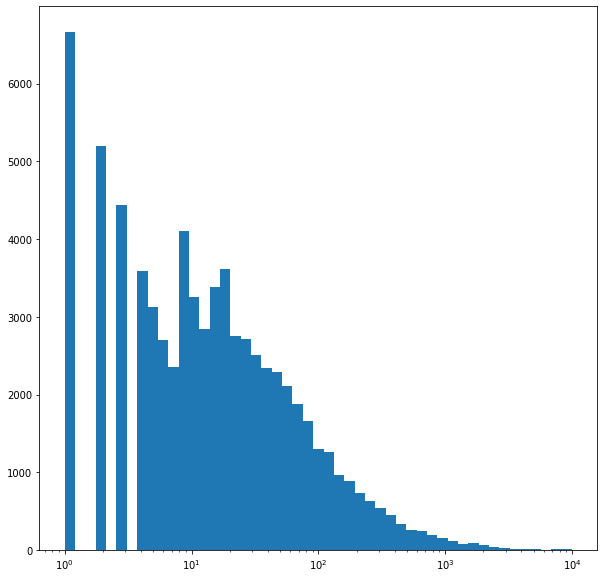

In [89]:
# analyze number of reviews distribution
import pylab as pl
import numpy as np

review_count_by_url = df.groupby(
    'url'
).agg(
    review_count=("review_count", "first")
)["review_count"]

print(review_count_by_url.max())

MIN, MAX = 1, 10000.0

pl.figure()
pl.hist(review_count_by_url, bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), 50))
pl.gca().set_xscale("log")
pl.show()

In [141]:
# get just the title and rating for each recipe
recipe_rating_title = df.groupby("url").agg(
    title=("title","first"),
    rating_stars=("rating_stars", "first")
)

recipe_rating_title["title"] = recipe_rating_title["title"].str.lower()

holidays = [
    "christmas",
    "new year's",
    "new years",
    "thanksgiving",
    "halloween",
    "4th of july",
    "fourth of july",
    "independence day",
]

holiday_regex = r"|".join(holidays)

holidays_recipes = recipe_rating_title.loc[
    recipe_rating_title['title'].str.contains(holiday_regex).fillna(False)
]

replace_dict = {}

for holiday in holidays:
    replace_dict[f".*{holiday}.*"] = holiday

holidays_recipes['holiday'] = holidays_recipes['title'].replace(
    replace_dict, regex=True
)

holiday_cleanup = {
    "new years": "new year's",
    "4th of july": "fourth of july",
    "independence day": "fourth of july"
}

holidays_recipes["holiday"] = holidays_recipes["holiday"].apply(
    lambda name: holiday_cleanup.get(name, name))

holidays_recipes

/tmp/ipykernel_68438/1512412415.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_recipes['holiday'] = holidays_recipes['title'].replace(
/tmp/ipykernel_68438/1512412415.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_recipes["holiday"] = holidays_recipes["holiday"].apply(


,title,rating_stars,holiday
url,,,
http://allrecipes.com/Recipe/10044/,belgian christmas cookies,3.83,christmas
http://allrecipes.com/Recipe/10062/,aunt zula's christmas cutouts,4.29,christmas
http://allrecipes.com/Recipe/10070/,christmas cornflake wreath cookies,4.34,christmas
http://allrecipes.com/Recipe/10091/,dora's christmas cookies,4.21,christmas
http://allrecipes.com/Recipe/10092/,christmas rocks,5.0,christmas
...,...,...,...
http://allrecipes.com/Recipe/9562/,christmas snack mix,4.38,christmas
http://allrecipes.com/Recipe/9564/,christmas crunch,4.15,christmas
http://allrecipes.com/Recipe/9595/,halloween cookies,2.71,halloween
